# **ĐỒ ÁN: NHẬP MÔN KHOA HỌC DỮ LIỆU** #

### Nhóm 7 ###
|<div style="width:150px">MSSV</div>|<div style="width:290px">Tên</div>|
|---------- |:-------------:|
| 20120041  |  Trần Kim Bảo |
| 20120053  |    Nguyễn Thành Đạt   | 
| 20120071  | Nguyễn Thị Bích Hà |
| 20120113  | Lê Nguyên Khang |

<h1 style="color:orange">PHẦN 1: QUY TRÌNH KHOA HỌC DỮ LIỆU</h1>

## <font color='orange'> Import thư viện </font> ##

In [1]:
!pip install scrapy
!pip install spider3

In [2]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import scrapy
from pandas.testing import assert_frame_equal # to compare two dataframes
# YOUR CODE HERE (OPTION) 
# Nếu cần các thư viện khác thì bạn có thể import thêm tại đây

## <font color='orange'> Mô tả trang web </font> ##

Trong đồ án này nhóm mình xin được giới thiệu đến mọi người danh sách phim hay nhất mọi thời đại *(Thời gian tính đến ngày 19/11/2022)* được trang IMDb tổng hợp. **IMDb** (<font color='blue'>https://www.imdb.com/</font>) là một trang cơ sở dữ liệu trực tuyến về điện ảnh thế giới, cung cấp thông tin về phim, diễn viên, đạo diễn, nhà làm phim,.. và tất cả những người, công ty trong lĩnh vực sản xuất phim, phim truyền hình và cả trò chơi video.

Những thông tin được thu thập tại website: <font color='blue'>https://www.imdb.com/list/ls006266261/</font>

### Tạo một project mới với scrapy ###

In [3]:
!scrapy startproject film_crawler

Error: scrapy.cfg already exists in /home/echkidieu/Desktop/YEAR3-SEM1/NM-KHDL/Project/week1/film_crawler


In [4]:
cd film_crawler/film_crawler

/home/echkidieu/Desktop/YEAR3-SEM1/NM-KHDL/Project/week1/film_crawler/film_crawler


---

## <font color='orange'> Thu thập thông tin từ web </font> ##
**<h5>1. Thu thập url, id, votes, gross của các phim </h5>**

In [5]:
%%writefile spiders/collect_film_urls.py
import scrapy

class collect_film_url(scrapy.Spider):
  name='film_urls' 
  
  def start_requests(self):
    urls=['https://www.imdb.com/list/ls006266261/?sort=list_order,asc&st_dt=&mode=detail&page=1']
    self.page=1
    yield scrapy.Request(url=urls[0], callback=self.parse)
        
  def parse(self, response):
    stt=response.css('div.lister-list span.lister-item-index.unbold.text-primary::text').getall()
    id=response.css('div.lister-list img::attr(data-tconst)').getall()
    url=response.css('div.lister-list div.lister-item.mode-detail div.lister-item-image.ribbonize a::attr(href)').re(r'.*/title/.*\d{4,10}.')
    for i in range(len(stt)):
      yield{
        'STT': stt[i],
        'ID':id[i],
        'URL':url[i],
        'Votes':response.xpath(f'//*[@id="main"]/div/div[4]/div[3]/div[{i+1}]/div[2]/p[4]/span[2]/@data-value').get(),
        'Gross':response.xpath(f'//*[@id="main"]/div/div[4]/div[3]/div[{i+1}]/div[2]/p[4]/span[5]/@data-value').get()
      }
    if self.page<11:
      self.page+=1
      next_page_url=f'https://www.imdb.com/list/ls006266261/?sort=list_order,asc&st_dt=&mode=detail&page={self.page}'
      yield scrapy.Request(url=next_page_url, callback=self.parse)
      

Overwriting spiders/collect_film_urls.py


- **Xuất các thông tin đã thu thập ở trên ra file json**

In [6]:
# !scrapy crawl film_urls -o dataset/film_urls.json

In [7]:
%%writefile spiders/collect_data_films.py
import scrapy
import pandas as pd
import numpy as np
from selenium import webdriver

class collect_data_film(scrapy.Spider):
  name='data_film'
  def __init__(self):
    try:
      df = pd.read_json('./dataset/film_urls.json', encoding='utf-8-sig')
      self.urls=df['URL']
    except IOError:
      print("File not found")
  def start_requests(self):
    self.headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:48.0) Gecko/20100101 Firefox/48.0'}
    for i in range(1000):
      next_page_url=f'https://www.imdb.com{self.urls[i]}?ref_=ttls_li_tt'
      yield scrapy.Request(url=next_page_url, callback=self.parse,headers=self.headers)

  def parse(self, response):

    # ID
    id_film=response.css('a.ipc-lockup-overlay.ipc-focusable::attr(href)').re(r'\w*\d{4,10}')[0]
    # Name
    name=response.css('h1[data-testid="hero-title-block__title"]::text').get()
    # Year release
    published_year=response.css("a[href*=releaseinfo]::text").re(r'\d{4}')[0]
    # Rate age
    age_rated=response.css("a[href*=certificates]::text").get()
    # Duration
    duration=response.css('div.ipc-metadata-list-item__content-container::text').getall()
    # Genres
    genres=response.css("a[href*=genres] span.ipc-chip__text::text").getall()
    
    # Director
    Director=set(response.css('ul.ipc-metadata-list.ipc-metadata-list--dividers-all.title-pc-list.ipc-metadata-list--baseAlt').xpath(".//*[contains(text(),'Director')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    # Writes
    Writers=set(response.css('ul.ipc-metadata-list.ipc-metadata-list--dividers-all.title-pc-list.ipc-metadata-list--baseAlt').xpath(".//*[contains(text(),'Writer')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    # Stars
    Stars=set(response.css('ul.ipc-metadata-list.ipc-metadata-list--dividers-all.title-pc-list.ipc-metadata-list--baseAlt').xpath(".//*[contains(text(),'Star')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    # Budget
    try:
      Budget=response.xpath(".//*[contains(text(),'Budget')]").xpath('following-sibling::div/ul/li/label/text()').re(r'^.?.*\s')[0]
    except:
      Budget=None

    #  IMDb rating
    IMDb_rating = response.css("span.sc-7ab21ed2-1::text").get()
    # Popularity
    popularity = response.css("div.sc-edc76a2-1::text").get()
    # User reviews
    user_reviews = response.css("span:contains(User\ reviews) span::text").get()
    # Critic reviews
    critic_reviews = response.css("span:contains(Critic\ reviews) span::text").get()
    # Metascore
    meta_score = response.css("span.score-meta::text").get()
    # Oscar wins
    wins = response.css("a[href*=awards]::text").get()
    
    yield {
      'ID':id_film,
      'Name':name,
      'Published Year':published_year,
      'Rated':age_rated,
      'Duration':duration,
      'Genres':genres,
      
      'Director':Director,
      'Writers':Writers,
      'Stars':Stars,
      'Budget (estimated)':Budget,
      
      "IMDb RATING": IMDb_rating,
      "Popularity" : popularity,
      "User reviews": user_reviews,
      "Critic reviews": critic_reviews,
      "Meta score": meta_score,
      "Wins": wins,
    }

Overwriting spiders/collect_data_films.py


In [8]:
# !scrapy crawl data_film -o dataset/data_film.json

---

## <font color='orange'> Khám phá dữ liệu và tiền xử lý </font> ##

<h2>Đọc dữ liệu</h2>
<h3>Đọc file film_urls vào dataframe<h3>

In [9]:
df_url=pd.read_json('dataset/film_urls.json',encoding='utf-8-sig')
df_url.head()

,STT,ID,URL,Votes,Gross
0,1.,tt0068646,/title/tt0068646/,1849463,"134,966,411"
1,2.,tt0099685,/title/tt0099685/,1156922,"46,836,394"
2,3.,tt0110912,/title/tt0110912/,2043441,"107,928,762"
3,4.,tt0114814,/title/tt0114814/,1083363,"23,341,568"
4,5.,tt0078788,/title/tt0078788/,666884,"83,471,511"


<h3>Đọc file data_film vào dataframe</h3>

In [10]:
df_film=pd.read_json('dataset/data_film.json',encoding='utf-8-sig')
df_film.head()

,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,Budget (estimated),IMDb RATING,Popularity,User reviews,Critic reviews,Meta score,Wins
0,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]","$6,000,000",9.2,92,5.2K,193,100.0,Won 3 Oscars
1,tt0108052,Schindler's List,1993,R,"[3, , hours, , 15, , minutes]","[Biography, Drama, History]",[Steven Spielberg],"[Steven Zaillian, Thomas Keneally]","[Liam Neeson, Ben Kingsley, Ralph Fiennes]","$22,000,000",9.0,219,2.1K,175,94.0,Won 7 Oscars
2,tt0137523,Fight Club,1999,R,"[2, , hours, , 19, , minutes]",[Drama],[David Fincher],"[Chuck Palahniuk, Jim Uhls]","[Edward Norton, Meat Loaf, Brad Pitt]","$63,000,000",8.8,139,4.3K,373,66.0,Nominated for 1 Oscar
3,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]","$6,000,000",8.5,425,1.4K,154,77.0,Won 2 Oscars
4,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]","$31,500,000",8.5,307,1.3K,302,94.0,Won 2 Oscars


<h3>Hợp dữ liệu lại</h3>

In [11]:
film_info_df=df_url.merge(df_film, on="ID", how="outer")
film_info_df.shape

(1000, 20)

In [12]:
film_info_df.head()

,STT,ID,URL,Votes,Gross,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,Budget (estimated),IMDb RATING,Popularity,User reviews,Critic reviews,Meta score,Wins
0,1.,tt0068646,/title/tt0068646/,1849463,"134,966,411",The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]","$6,000,000",9.2,92,5.2K,193,100.0,Won 3 Oscars
1,2.,tt0099685,/title/tt0099685/,1156922,"46,836,394",Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]","$25,000,000",8.7,194,1.5K,163,90.0,Won 1 Oscar
2,3.,tt0110912,/title/tt0110912/,2043441,"107,928,762",Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]","$8,000,000",8.9,115,3.5K,306,94.0,Won 1 Oscar
3,4.,tt0114814,/title/tt0114814/,1083363,"23,341,568",The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]","$6,000,000",8.5,425,1.4K,154,77.0,Won 2 Oscars
4,5.,tt0078788,/title/tt0078788/,666884,"83,471,511",Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]","$31,500,000",8.5,307,1.3K,302,94.0,Won 2 Oscars


<h3>Thực hiện sắp xếp lại các cột để tiện cho việc quan sát dữ liệu hơn</h3>

In [13]:
film_info_df=film_info_df[['STT','ID','Name','Published Year','Rated','Duration','Genres','Director','Writers','Stars','IMDb RATING'\
    ,'Budget (estimated)','Gross','Popularity','Votes','User reviews','Critic reviews','Meta score','Wins','URL']]

In [14]:
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1.,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,"$6,000,000","134,966,411",92,1849463,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2.,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,"$25,000,000","46,836,394",194,1156922,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3.,tt0110912,Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,"$8,000,000","107,928,762",115,2043441,3.5K,306,94.0,Won 1 Oscar,/title/tt0110912/
3,4.,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,"$6,000,000","23,341,568",425,1083363,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5.,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,"$31,500,000","83,471,511",307,666884,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/


<h2>Bắt đầu khám phá dữ liệu</h2>

<h3>Dữ liệu có bao nhiêu dòng, bao nhiêu cột?</h3>

In [15]:
num_rows, num_cols = film_info_df.shape
num_rows, num_cols

(1000, 20)

<h3>Mỗi dòng có ý nghĩa gì?</h3>

<h4>Mỗi dòng là thông tin chi tiết của các các phim trong danh sách , không có dòng nào có ý nghĩa khac với các dòng còn lại.</h4>

<h3>Kiểm tra xem có dữ liệu trùng nhau không?</h3> 

- Ở đây ID mang tính định danh cho từng phim, ta sẽ kiểm tra xem thử có ID phim nào trùng nhau không

In [16]:
check_duplucate=set(film_info_df.ID.duplicated())
if True in check_duplucate:
    have_duplicated_rows = True
else:
    have_duplicated_rows = False

In [17]:
# TEST
assert have_duplicated_rows == False

<h5>Không có dòng nào bị lặp</h5>

<h3> Mỗi cột có ý nghĩa gì?</h3>

|STT|Tên cột dữ liệu | <center>Mô tả<center> | Đơn vị |
|--|:------:| ---| --- |
|1|Top|<center>Thể hiện thứ hạng của phim trên bảng xếp hạng<center>|
|2|ID| <center>Mã định danh của phim<center>|
|3|Name|<center>Tên của phim<center>|
|4|Published Year| <center>Năm xuất bản phim<center>| năm |
|5|Rated|<center>Loại phim dựa trên Hệ thống phân loại phim của MPAA, để phân loại phim cho các đối tượng xem trẻ em, thanh thiếu niên và người lớn<center>|  | 
|6|Duration|<center>Thời lượng phim<center>|  giờ
|7|Genres|<center>Thể loại phim<center>|  |
|8|Director|<center>Tên các đạo diễn sản xuất phim<center>| |
|9|Writers|<center>Tên các biên kịch phim<center>|  |
|10|Stars|<center>Tên các diễn viên tham gia (ở cột này chỉ lấy tên các diễn viên được hiển thị trên trang web)<center>|  |
|11|IMDb RATING|<center>Điểm IMDb được tính theo thang điểm 10, nghĩa là nếu điểm số càng cao thì chất lượng càng tốt<center>| |
|12|Budget (estimated)|<center>Kinh phí thực hiện phim (ước tính)<center>| \$ |
|13|Gross|<center>Doanh thu của phim tính đến thời điểm hiện tại<center>| \$ |
|14|Popularity|<center>Độ phổ biến của phim (thứ tự trên bảng xếp hạng) được tính đến tuần hiện tại<center>|  |
|15|Votes|<center>Số lượt bình chọn của người xem trên trang IMDb dành cho phim<center>|  |
|16|User reviews|<center>Số lượng nhận xét của người xem<center>|  |
|17|Critic reviews|<center>Số lượng nhận xét của các nhà phê bình<center>|  |
|18|Meta score|<center>Điểm trung bình của các nhà phê bình lấy từ bộ điểm số của Metacritic, với thang điểm là 100<center>|  |
|19|Wins|<center>Số lượng giải thưởng và đề cử mà phim đạt được trong Giải thưởng Viện Hàn lâm, thường được biết đến với tên Giải Oscar<center>|
|20|URL|<center>Địa chỉ truy cập vào trang web mô tả chi tiết của phim<center>|



* **Thời điểm hiện tại** là tính đến ngày 12/11/2021

<h3>Kiểm tra xem mỗi cột hiện đang có kiểu dữ liệu gì?</h3>

In [18]:
film_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STT                 1000 non-null   object 
 1   ID                  1000 non-null   object 
 2   Name                1000 non-null   object 
 3   Published Year      1000 non-null   int64  
 4   Rated               997 non-null    object 
 5   Duration            1000 non-null   object 
 6   Genres              1000 non-null   object 
 7   Director            1000 non-null   object 
 8   Writers             1000 non-null   object 
 9   Stars               1000 non-null   object 
 10  IMDb RATING         1000 non-null   float64
 11  Budget (estimated)  895 non-null    object 
 12  Gross               937 non-null    object 
 13  Popularity          782 non-null    object 
 14  Votes               1000 non-null   int64  
 15  User reviews        1000 non-null   object 
 16  Critic 

<h3>Khoảng biểu diễn của kiểu dữ liệu đó như thế nào?</h3>

In [19]:
# YOUR CODE HERE

<h3>Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp hay không?</h3>

In [20]:
# YOUR CODE HERE

<h3>Với mỗi cột, dữ liệu phân bố như thế nào?</h3>

In [21]:
film_info_df.columns

Index(['STT', 'ID', 'Name', 'Published Year', 'Rated', 'Duration', 'Genres',
       'Director', 'Writers', 'Stars', 'IMDb RATING', 'Budget (estimated)',
       'Gross', 'Popularity', 'Votes', 'User reviews', 'Critic reviews',
       'Meta score', 'Wins', 'URL'],
      dtype='object')

In [22]:
film_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STT                 1000 non-null   object 
 1   ID                  1000 non-null   object 
 2   Name                1000 non-null   object 
 3   Published Year      1000 non-null   int64  
 4   Rated               997 non-null    object 
 5   Duration            1000 non-null   object 
 6   Genres              1000 non-null   object 
 7   Director            1000 non-null   object 
 8   Writers             1000 non-null   object 
 9   Stars               1000 non-null   object 
 10  IMDb RATING         1000 non-null   float64
 11  Budget (estimated)  895 non-null    object 
 12  Gross               937 non-null    object 
 13  Popularity          782 non-null    object 
 14  Votes               1000 non-null   int64  
 15  User reviews        1000 non-null   object 
 16  Critic 

<h3>Ta thấy một số vấn đề cần giải quyết:</h3>

- Các cột STT, Duration, Budget, Gross, Popularity, User reviews, Critic reviews là những cột đúng ra có dạng dữ liệu numerical.

#### Xử lý cột `STT`:
- Chuyển về kiểu dữ liệu int

In [23]:
film_info_df.STT=film_info_df.STT.replace(',','',regex=True).replace('\.','',regex=True).astype(int)

#### Xử lý cột `Duration`:
- Chuyển về kiểu dữ liệu float ứng với đơn vị phút

In [24]:
def transform_duration(duration):
    if (len(duration) == 3):
        tmp_dur = duration[0]
        tmp_dur = float(tmp_dur) * 60
        return tmp_dur
    elif (len(duration) == 7):
        tmp_dur1 = duration[0] 
        tmp_dur1 = float(tmp_dur1) * 60

        tmp_dur2 = duration[4] 
        tmp_dur2 = float(tmp_dur2)
        tmp_dur = tmp_dur1 + tmp_dur2
        return tmp_dur    

In [25]:
film_info_df['Duration'] = film_info_df['Duration'].apply(transform_duration)

In [26]:
# TEST
assert film_info_df['Duration'].dtype in [np.float32, np.float64]

#### Xử lý `Budget`:
- Chuyển về kiểu dữ liệu float ứng với đơn vị \$

In [27]:
def exchange_rate(currency):
    currency = str(currency)
    l = len(currency)
    if currency == 'None':
        bbudget = np.nan
        tmp_cur = '0'
    elif currency[0] == '$':
        bbudget = 1
        tmp_cur = currency[1:l]
    elif currency[0] == '£':
        bbudget = 1.22
        tmp_cur = currency[1:l]
    elif currency[0] == '€':
        bbudget = 1.05
        tmp_cur = currency[1:l]
    elif currency[0] == '¥':
        bbudget = 0.0073
        tmp_cur = currency[1:l]
    elif currency[0] == '₹':
        bbudget = 0.012
        tmp_cur = currency[1:l]
    elif currency[0:2] == 'R$':
        bbudget = 0.19
        tmp_cur = currency[2:l]
    elif currency[0:2] == 'A$':
        bbudget = 0.68
        tmp_cur = currency[2:l]
    elif currency[0:3] == 'CA$':
        bbudget = 0.74
        tmp_cur = currency[3:l]
    else:
        currency = str(currency)
        tmp_currency = currency.split()
        if tmp_currency[0] == 'FRF':
            bbudget = 0.161
        elif tmp_currency[0] == 'DEM':
            bbudget = 0.54
        elif tmp_currency[0] == 'NOK':
            bbudget = 0.1
        elif tmp_currency[0] == 'MVR':
            bbudget = 0.065
        tmp_cur = currency[4: l]
    tmp_cur = tmp_cur.replace(' ', '')
    tmp_cur = tmp_cur.replace(',', '')
    tmp_cur = float(tmp_cur)
    tmp_cur = tmp_cur*bbudget
    return tmp_cur

In [28]:
film_info_df["Budget (estimated)"] = film_info_df["Budget (estimated)"].apply(exchange_rate)

In [29]:
# TEST
assert film_info_df['Budget (estimated)'].to_list()[:5] == [6000000.0, 25000000.0, 8000000.0, 6000000.0, 31500000.0]
assert film_info_df['Budget (estimated)'].to_list()[-5:] == [54000000.0, 25000000.0, 65000000.0, 8500000.0, 110000000.0]

#### Xử lý cột `Gross`:
- Chuyển về kiểu dữ liệu float ứng với đơn vị USD

In [30]:
film_info_df.Gross=film_info_df.Gross.replace([",",None],['',np.nan],regex=True).astype(float)

#### Xử lý cột `Popularity`:
- Chuyển về kiểu dữ liệu int

In [31]:
film_info_df.Popularity=film_info_df.Popularity.replace(',','',regex=True).astype(float)

#### Xử lý cột `User reviews`:
- Chuyển về kiểu dữ liệu float

In [32]:
def User_reviews_to_float(col_df):
    col_convert = []
    for i in film_info_df['User reviews']:
        if (str(i) != 'None'):
            Usr = str(i)
            if Usr[-1] == 'K':
                Usr = Usr.replace('K', '')
                Usr = float(Usr) * 1000
                col_convert.append(Usr)
            else:
                col_convert.append(float(Usr))
        else:
            col_convert.append(0.0)
    film_info_df['User reviews'] = col_convert

User_reviews_to_float(film_info_df['User reviews'])

#### Xử lý cột `Critic reviews`:
- Chuyển về kiểu dữ liệu float

In [33]:
def Critic_reviews_to_float(col_df):
    col_convert = []
    for i in film_info_df['Critic reviews']:
        if (str(i) != 'None'):
            Crr = str(i)        
            if Crr[-1] == 'K':
                Crr = Crr.replace('K', '')
                Crr = float(Crr) * 1000
            else:
                Crr = float(Crr)
            col_convert.append(Crr)
        else:
            col_convert.append(0.0)
    film_info_df['Critic reviews'] = col_convert

Critic_reviews_to_float(film_info_df['Critic reviews'])

In [34]:
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/


<h3>Phân bố dữ liệu ở các cột:</h3>

<h3>Với các cột có kiểu dữ liệu dạng số:</h3>

<h4>Với các cột có kiểu dữ liệu số, ta tính:</h4>

- Tỉ lệ % các giá trị thiếu
- Giá trị min
- Phân vị thứ 1
- Trung vị
- Phân vị thứ 3
- Giá trị max

In [35]:
# YOUR CODE HERE
col = [] 
for i in film_info_df.columns: 
    if film_info_df[i].dtype in [np.float32, np.float64] or film_info_df[i].dtype in [np.int32, np.int64]:
        col.append([])

def get_median(median, index, l, r):
    ll = r - l
    if ll % 2 != 0:
        return(median[index + ll//2])
    else:
        return((median[index + ll//2 - 1] + median[index + ll//2]) / 2)

len_col = len(film_info_df["Name"])

columee = []  
count = -1
for i in film_info_df.columns:
    missing_ratio = 0
    median = []
    minn = 1000000000
    maxx = 0
    if film_info_df[i].dtype in [np.float32, np.float64] or film_info_df[i].dtype in [np.int32, np.int64]:
        columee.append(i)
        count += 1
        for j in film_info_df[i]: 
            if (str(j) == 'nan'):
                missing_ratio += 1
            if minn > j :
                minn = j
            if (str(j) != 'nan'):
                median.append(j)
            if maxx < j :
                maxx = j

        col[count].append(round(missing_ratio*100 / len_col, 1))
        col[count].append(minn)

        median = sorted(median)
        ll = len(median) 

        mid = (0 + ll)//2
        if ll % 2 != 0 : 
            col[count].append(get_median(median, 0, 0, int(mid)))
        else:
            col[count].append(get_median(median, 0, 0, int(mid)))

        ll = len(median)
        if ll % 2 != 0:
            col[count].append(median[ll//2])
        else:
            col[count].append((median[ll//2 - 1] + median[ll//2]) / 2)

        if ll % 2 != 0 : 
            col[count].append(get_median(median, int(mid) + 1, int(mid) + 1, int(ll) ))
        else:
            col[count].append(get_median(median, int(mid), int(mid), int(ll) ))

        col[count].append(maxx)
        
 
num_col_info_df = pd.DataFrame()
indexx = ["missing_ratio", "min", "lower_quantile", "median", "upper_quantile", "max"]
num_col_info_df['indexx'] = indexx
num_col_info_df = num_col_info_df.set_index('indexx')

index_columee = 0
for i in columee:
    num_col_info_df[i] = col[index_columee]
    index_columee += 1

In [36]:
num_col_info_df

,STT,Published Year,Duration,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score
indexx,,,,,,,,,,,
missing_ratio,0.0,0.0,0.0,0.0,10.5,6.3,21.8,0.0,0.0,0.0,3.7
min,1.0,1933.0,70.0,5.3,1.3,2647.0,42.0,1503.0,7.0,14.0,31.0
lower_quantile,250.5,1988.0,100.0,7.2,4880000.0,6254939.5,690.0,76670.0,254.0,114.5,66.0
median,500.5,2000.0,113.0,7.6,15000000.0,33395426.0,1384.5,188223.0,487.0,174.5,75.0
upper_quantile,750.5,2009.0,128.0,7.9,40000000.0,100165949.5,2556.0,410885.0,924.5,285.5,83.0
max,1000.0,2020.0,334.0,9.3,321000000.0,936662225.0,4980.0,2668718.0,10500.0,1000.0,100.0


<h4>Với các cột thì không phải dạng:</h4>

- Tỉ lệ % các giá trị thiếu
- Số lượng các gía trị khác nhau
- Tỉ lệ % của các giá trị đó 

In [37]:
cols_film = ['Rated', 'Wins', 'Genres', 'Director', 'Writers', 'Stars']

# Các cột ứng với câu hỏi khảo sát multichoice
multichoice_cols = [ 'Genres', 'Director', 'Writers', 'Stars' ]

In [38]:
pd.set_option('display.max_colwidth', 100) # Để dễ nhìn
pd.set_option('display.max_columns', None) # Để dễ nhìn
col = [] 

for i in film_info_df.columns: 
    if i in cols_film:
        col.append([])

len_col = len(film_info_df['Genres'])
count = -1
used = []
columee = []
for i in film_info_df.columns:
    used.clear()
    missing_ratio = 0
    num_values = 0
    if i in cols_film:
        columee.append(i)
        count += 1
        for j in film_info_df[i]: 
            if (str(j) == 'None'):
                missing_ratio += 1

        col[count].append(round(missing_ratio*100 / len_col, 1))

        if i not in multichoice_cols:
            for j in film_info_df[i]: 
                if (str(j) != 'None' and j not in used):
                    used.append(j)
                    num_values += 1
            col[count].append(num_values)
        else:
            for j in film_info_df[i]:
                if (str(j) != 'None'):
                    for k in j:
                        if (k not in used):
                            used.append(k)
                            num_values += 1
            col[count].append(num_values)

        dictCol = {}
        count_key = 0
        if i not in multichoice_cols:
            for j in film_info_df[i]: 
                if (str(j) != 'None' and j not in dictCol):
                    dictCol[j] = 1
                    count_key += 1
                elif str(j) != 'None':
                    dictCol[j] = dictCol[j] +1
                    count_key += 1
        else:
            for j in film_info_df[i]: 
                if (str(j) != 'None'):
                    # tmp = j.split(';')
                    for k in j:
                        if (k not in dictCol):
                            dictCol[k] = 1
                            count_key += 1
                        else:
                            dictCol[k] = dictCol[k] +1
                            count_key += 1
        for j in dictCol:
            dictCol[j] = round(dictCol[j]*100 / count_key, 1)

        items_sorted = sorted(dictCol.items(),reverse=True, key = lambda x : x[1]) # sắp xếp từ điển giảm dần 
        dictCol_sort = {}
        for i in items_sorted :
            dictCol_sort[i[0]] = i[1]

        col[count].append(dictCol)        

cat_col_info_df = pd.DataFrame()
indexx = ["missing_ratio", "num_values", "value_ratios"]
cat_col_info_df['indexx'] = indexx
cat_col_info_df = cat_col_info_df.set_index('indexx')

index_columee = 0
for i in columee:
    cat_col_info_df[i] = col[index_columee]
    index_columee += 1

In [39]:
cat_col_info_df

,Rated,Genres,Director,Writers,Stars,Wins
indexx,,,,,,
missing_ratio,0.3,0.0,0.0,0.0,0.0,1.6
num_values,13,22,579,1388,1739,29
value_ratios,"{'R': 57.9, 'PG': 10.7, 'PG-13': 18.0, 'G': 2.5, 'NC-17': 0.8, 'X': 0.3, 'Approved': 1.6, 'Not R...","{'Crime': 11.4, 'Drama': 22.2, 'Biography': 4.1, 'Mystery': 4.5, 'War': 0.9, 'History': 1.3, 'Th...","{'Francis Ford Coppola': 0.5, 'Martin Scorsese': 1.6, 'Quentin Tarantino': 0.8, 'Bryan Singer': ...","{'Francis Ford Coppola': 0.2, 'Mario Puzo': 0.2, 'Nicholas Pileggi': 0.1, 'Martin Scorsese': 0.1...","{'Al Pacino': 0.5, 'Marlon Brando': 0.1, 'James Caan': 0.1, 'Ray Liotta': 0.1, 'Robert De Niro':...","{'Won 3 Oscars': 2.6, 'Won 1 Oscar': 10.8, 'Won 2 Oscars': 4.8, 'Nominated for 1 Oscar': 11.8, '..."


---

<h2 style="color:orange">Lấy dữ liệu mô hình:</h2>

- <h4>Với yêu cầu dữ liệu chạy mô hình là dữ liệu đã qua tiền xử lý. Không có tự ý thêm hay bớt gì từ dữ liệu gốc</h4>

In [42]:
cluster_full_info_df=film_info_df.copy()
cluster_full_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/


---


## <font color='orange'> Câu hỏi đặt ra </font> ##

<h3>Câu 1:

- Phân tích trong 10 năm để tìm ra thể loại phim được yêu thích trong mỗi khoảng thời gian.
- Tương quan giữa các thể loại (genre) với doanh thu, độ nổi tiếng, các thành tựu đạt được
</h3>

- Ý nghĩa khi trả lời câu hỏi:
    - Biết được thể loại phim nào được yêu thích nhất trong mỗi thập niên.
    - Thể loại được yêu thích có phải chỉ tập trung vào một vài thập niên không, hay là gần như được yêu thích với mọi thập niên
    - Hiểu rõ được thể loại được yêu thích là do gì
- Các bước thực hiện:
    - Bước 1: Thống kê số lượng phim theo thập niên, cho ta biết số lượng của phim thay đổi theo từng thập niên như thế nào (sự bất thường ở thập niên 2020, có sự sụt giảm trong thập niên 2010)
    - Bước 2: Thống kê số lượng phim theo thể loại, xem các thể loại được yêu thích cho tới hiện tại. Là bước xử lý trước để nhận xét cho bước tiếp theo, với số lượng phim của thể loại đó lọt top nhiều như thế, thì có phải chỉ mới nổi trong vài thập niên hay là trong các thập niên đều được yêu thích như vậy.(được trả lời trong bước tiếp theo)
    - Bước 3: Tương quan giữa thể loại phim và thập niên: Khẳng định sự yêu thích của thể loại qua từng thập niên
    -Bước 4: So sánh với các cột khác để xem có thực phải là thể loại được yêu thích thì sẽ mang nhiều doanh thu về không, hay là có phải thể loại được yêu thích sẽ là những yếu tố đóng góp nhiều cho các giải thưởng của phim không.

*Yêu thích: Nhóm dùng ở đây ý do là danh sách phim hay nên xuất hiện trong danh sách được xem như là yêu thích.*

<h3>Bước 1: Thống kê số lượng phim theo thập niên</h3>

In [142]:
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/


<h5>Kiểm tra xem thử có phim nào không có năm ra mắt không?</h5>

In [143]:
film_info_df['Published Year'].isnull().any()

False

In [144]:
film_info_df['Published Year'].unique()

array([1972, 1990, 1994, 1995, 1979, 1996, 1999, 1993, 1997, 1992, 1975,
       1976, 1985, 1974, 2008, 1983, 2001, 1986, 1998, 1980, 2009, 2006,
       2002, 1984, 1973, 2000, 1981, 1988, 1942, 2010, 1987, 2005, 1971,
       2011, 1982, 1941, 2004, 2003, 1991, 1989, 2012, 1957, 1964, 2007,
       1946, 1977, 1966, 2013, 1978, 1969, 1967, 1939, 1954, 1968, 1960,
       2018, 2019, 1962, 1961, 2014, 2015, 2016, 1949, 1959, 1970, 2017,
       1955, 1950, 1956, 1963, 1958, 1940, 1948, 1965, 1938, 2020, 1952,
       1944, 1933, 1934, 1947])

<h5>Chia khoảng các phim theo cụm 10 năm</h5>

In [145]:
def decade(vl):
       return int(np.floor(vl/10)*10)

film_info_df.insert(4,"Decade",film_info_df['Published Year'].apply(decade),True)

In [146]:
film_info_df.head()

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,1970,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,1990,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,1990,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,1970,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/


<h5>Cùng vẽ biểu đồ  xem số lượng phim thay đổi thế nào giữa các thập kỉ nào</h5>

In [147]:
film_decade=film_info_df.Decade.value_counts().sort_index()
film_decade

1930      6
1940     16
1950     19
1960     39
1970     76
1980    124
1990    215
2000    282
2010    222
2020      1
Name: Decade, dtype: int64

In [148]:
film_info_df[film_info_df.Decade==2020]

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
774,775,tt6723592,Tenet,2020,2020,PG-13,150.0,"[Action, Sci-Fi, Thriller]",[Christopher Nolan],[Christopher Nolan],"[John David Washington, Robert Pattinson, Elizabeth Debicki]",7.3,205000000.0,58456624.0,242.0,502061,5500.0,510.0,69.0,Won 1 Oscar,/title/tt6723592/


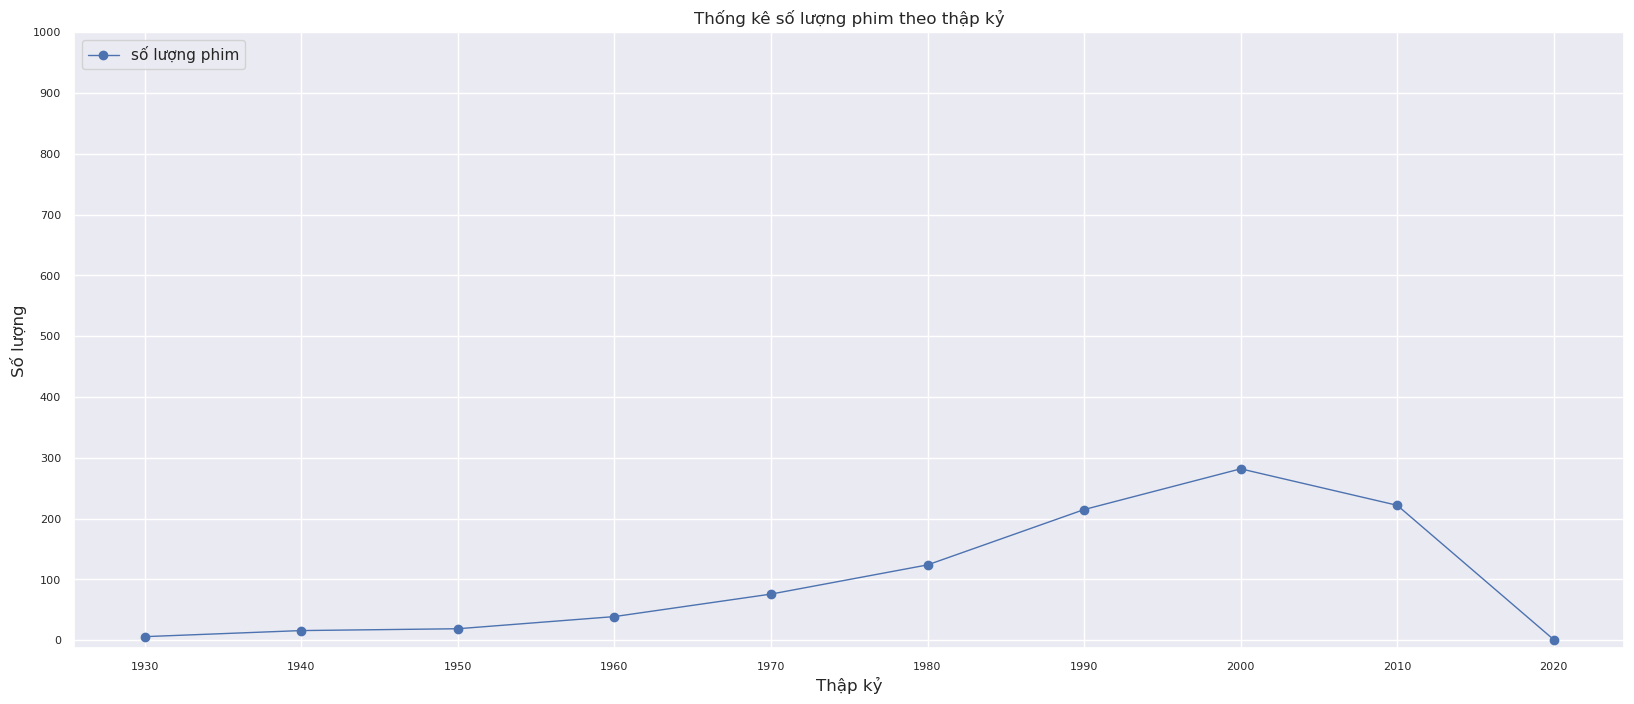

In [149]:

fig =plt.subplots(figsize=(20,8))

decade=np.array(film_decade.keys())
num_film=np.array(film_decade.values)

plt.plot(decade,num_film,marker='o',linestyle='-',linewidth=1,label='số lượng phim')
plt.xlabel('Thập kỷ')
plt.ylabel('Số lượng')
plt.title('Thống kê số lượng phim theo thập kỷ')
plt.xticks(decade,size=8)
plt.yticks(range(0,1001,100),size=8)
plt.legend(loc='upper left')
plt.show()

<h4>Nhận xét:</h4>

- Khi thực hiện đồ án, danh sách tổng hợp cập nhật lần gần nhất là 12/11/2021. Và với tình hình dịch bệnh các năm 2020, 2021 ở trên khắp thế giới, nên ta có thể thấy chỉ có 1 phim [Tenet](https://www.imdb.com/title/tt6723592/) là nằm trong [top 1000 phim](https://www.imdb.com/list/ls006266261/).<br>

- Và ta cũng có thể thấy được sự thay đổi rõ rệt về số lượng phim lọt top từ thập niên 1930 đến thập niên 2000 (tăng dần), tuy nhiên có 1 sự sụt giảm vào thập niên 2010 lúc công nghệ làm phim phát triển hơn hắn những thập niên trước (liệu rằng có yếu tố nào tác động đằng sau, chúng ta sẽ cố trả lời nó vào những phần sau nhé).


<h3>Bước 2: Thống kê số lượng phim theo thể loại</h3>

<h5>Tiếp tục chia ra xem những thể loại nào nhiều nhất nhé</h5>

In [150]:
film_info_df.Genres.explode().unique()

array(['Crime', 'Drama', 'Biography', 'Mystery', 'War', 'History',
       'Thriller', 'Adventure', 'Comedy', 'Sci-Fi', 'Action', 'Sport',
       'Romance', 'Animation', 'Horror', 'Fantasy', 'Western', 'Family',
       'Documentary', 'Music', 'Film-Noir', 'Musical'], dtype=object)


<h4>Ở đây, ta thấy hơi lạ sao lại có 2 thể loại Music và Musical, liệu dữ liệu có bị trùng hay gì không?</h4>


<h4>Câu trả lời là <b>không</b> nhé:</h4>

- Music: thể loại có liên quan đến âm nhạc ví dụ như một câu chuyện về một bản nhạc, hay đại loại như vậy.</br>
- Musical: thể loại nhạc kịch, tràn đầy những bản nhạc, kết hợp với những điệu nhảy cuốn hút người xem.</br>

[Chi tiết](https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG#)


In [151]:
film_genre=film_info_df.Genres.explode().value_counts()
film_genre

Drama          573
Crime          293
Comedy         279
Action         254
Thriller       191
Adventure      181
Mystery        117
Biography      106
Horror          93
Romance         92
Sci-Fi          91
Fantasy         56
Documentary     50
Animation       34
History         34
Music           31
War             24
Family          23
Sport           23
Western         17
Film-Noir        8
Musical          6
Name: Genres, dtype: int64

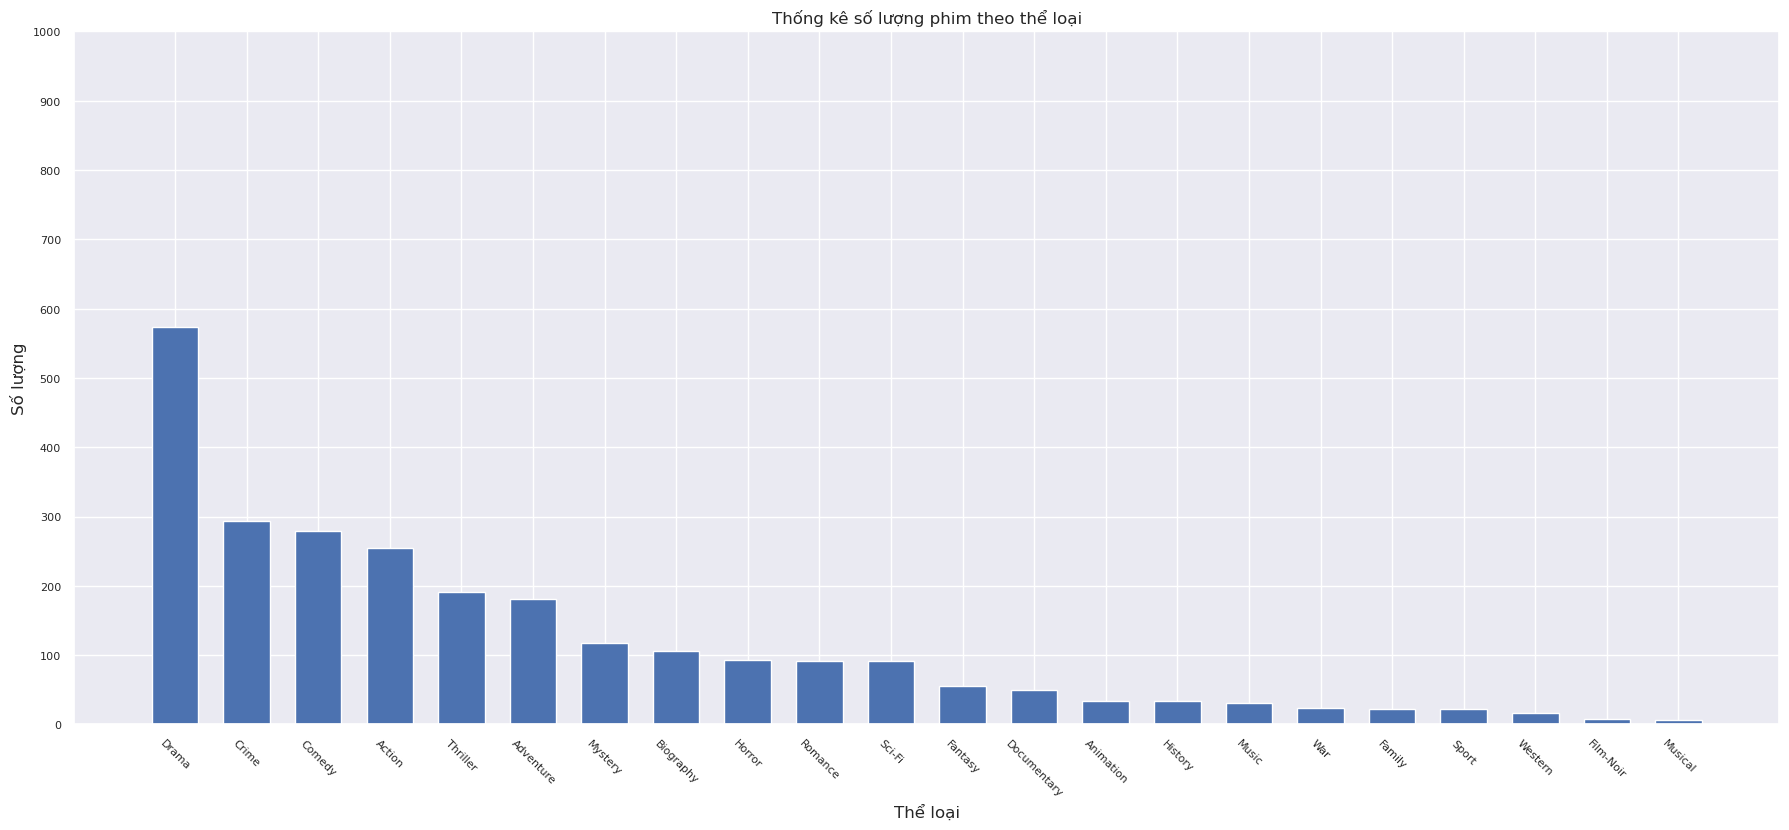

In [152]:
fig =plt.subplots(figsize=(22,9))

genre=np.array(film_genre.keys())
num_film=np.array(film_genre.values)

plt.bar(genre,num_film,width=0.65)
plt.xlabel('Thể loại')
plt.ylabel('Số lượng')
plt.title('Thống kê số lượng phim theo thể loại')
plt.xticks(genre,size=8)
plt.yticks(range(0,1001,100),size=8)
plt.setp(plt.gca().get_xticklabels(), rotation=-45, horizontalalignment='center')
plt.show()

<h4>Nhận xét:</h4>

- Nhìn biểu đồ ta thấy được xu hướng lọt top phim của các phim pha trộn(hoặc tập trung) vào thể loại drama chiếm hơn 1 nửa số lượng phim và cũng là thể loại chiếm số lượng cao nhất. Thể loại được kết hợp nhiều các yếu tố tâm lý xã hội, bi – hài tạo nên một tổng thể mang lại nhiều cảm xúc đan xen cho người xem.<br>
- Tiếp đến là các thể loại phổ biến như: phim tội phạm, hài kịch, hành động, giật gân, phiêu lưu: cũng là những thể loại chiếm đa số. Ở đây trừ hài kịch mục đích gây cười, có tính giải trí cao (*điều ai cũng cần*), thì có thể thấy gần như hầu hết đều là những thể loại mạnh mẽ, nhịp độ phim nhanh gây kích thích, hứng thú cho người xem.<br>
- Các thể loại còn lại chỉ chiếm từ 0 đến 10% số lượng phim trong danh sách.

<h3>Bước 3: Tương quan giữa thể loại phim và thập niên(Ở trên ta có giải thích qua, nên ở đây sẽ không xét thập niên 2020)</h3>

<h4>Cùng xem sự tương quan giữa thể loại phim từng thập niên như thế nào nhé</h4>

In [153]:
film_genre_decade=film_info_df[~film_info_df.Decade.isin([2020])].explode('Genres').value_counts(['Decade','Genres']).to_frame().reset_index([0,1])
film_genre_decade

,Decade,Genres,0
0,2000,Drama,169
1,1990,Drama,131
2,2010,Drama,124
3,2000,Crime,82
4,2000,Action,80
...,...,...,...
152,1960,Sport,1
153,1960,Animation,1
154,1960,Fantasy,1
155,1960,History,1


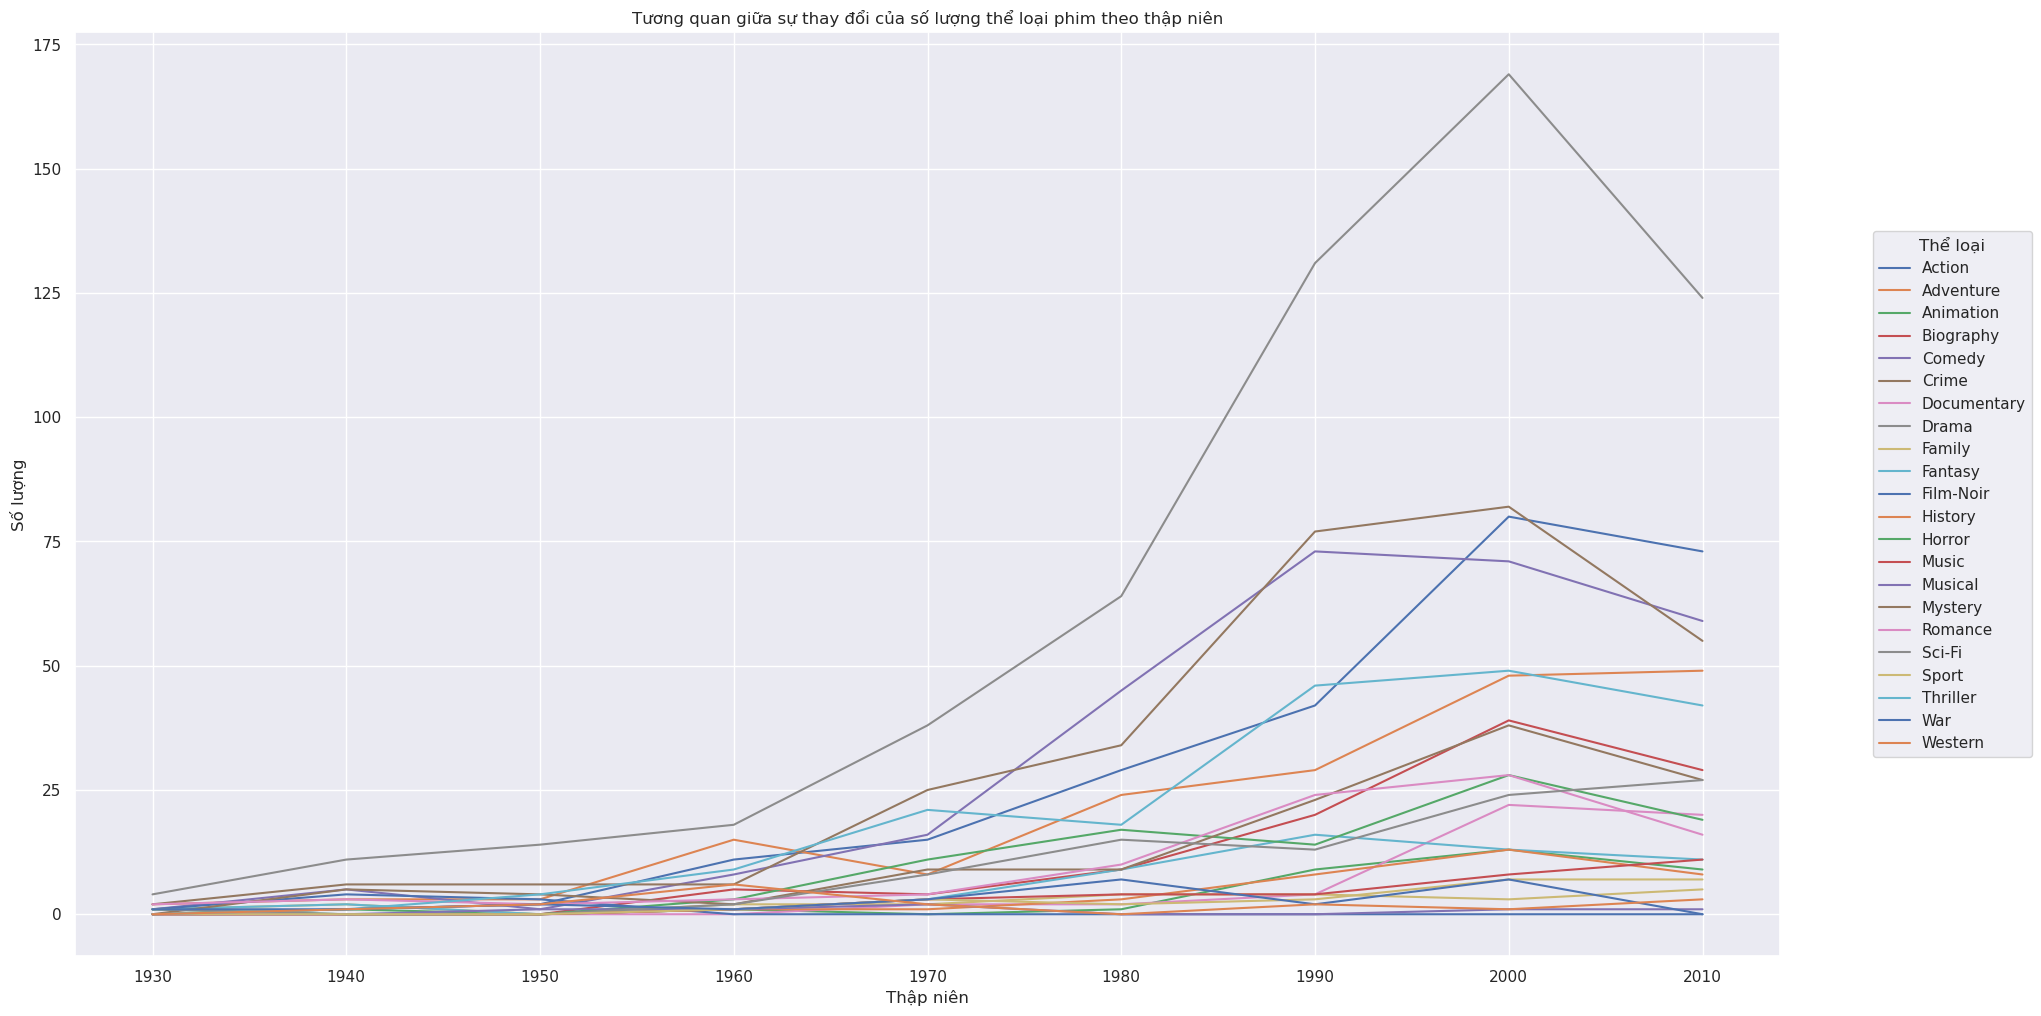

In [154]:
num_film_each_genre=film_genre_decade.pivot('Decade','Genres',0)
num_film_each_genre=num_film_each_genre.sort_index().fillna(0)

fig =plt.subplots(figsize=(22,12))

genre=np.array(film_genre.keys())
num_film=np.array(film_genre.values)

plt.plot(num_film_each_genre)
plt.xlabel('Thập niên')
plt.ylabel('Số lượng')
plt.title('Tương quan giữa sự thay đổi của số lượng thể loại phim theo thập niên')
plt.legend(num_film_each_genre.columns,title='Thể loại',loc='center left',bbox_to_anchor=(1.05,0.5))
plt.show()

<h4>Nhận xét:</h4>

- Ta thấy rằng ở thể loại Drama ở mọi thập niên đều đứng đầu trong số lượng phim lọt top. Nên có thể trả lời là không phải chỉ được yêu thích trong vài thập niên, mà thể loại Chính kịch luôn là thể loại được yêu thích nhất từ trước đến nay.<br>
- Ở các thể loại khác có sự thay đổi theo từng thập niên(Không có sự thay đổi nhiều trong các thể loại: hành động, hài kịch, phiêu lưu, tội phạm).<br>
- Vì số lượng phim lọt top của thập niên 2010 giảm hơn 1/5 so với thập niên 2000, nên ta có thể thấy rắng chỉ vài thể loại tăng lên. Tuy rằng nhu cầu giải trí mỗi ngày càng cao, số lượng phim sản xuất cũng tăng lên và có nhiều sự khác biệt trong công nghệ làm phim.

<h3>Bước 4: Tương quan theo những chuẩn khác</h3>

<h4>Tổng doanh thu do thể loại đó mang lại</h4>

- Xử lý qua dữ liệu trước khi làm 

In [155]:
film_info_df.Gross=film_info_df.Gross.replace(np.nan,0)

In [156]:
# pd.set_option('display.max_colwidth',None)
sum_gross_genres=film_info_df.explode('Genres').groupby('Genres')['Gross'].sum().multiply(10**-7)
sum_gross_genres

Genres
Action         3123.458439
Adventure      2969.915042
Animation       522.219539
Biography       333.077834
Comedy         1795.045785
Crime          1130.544314
Documentary      50.792800
Drama          2736.377711
Family          251.515777
Fantasy         682.477792
Film-Noir         1.705491
History         145.154775
Horror          338.141635
Music           119.770309
Musical          11.823718
Mystery         543.231261
Romance         573.709122
Sci-Fi         1208.727696
Sport            65.319427
Thriller       1067.951572
War             122.148509
Western          81.141154
Name: Gross, dtype: float64

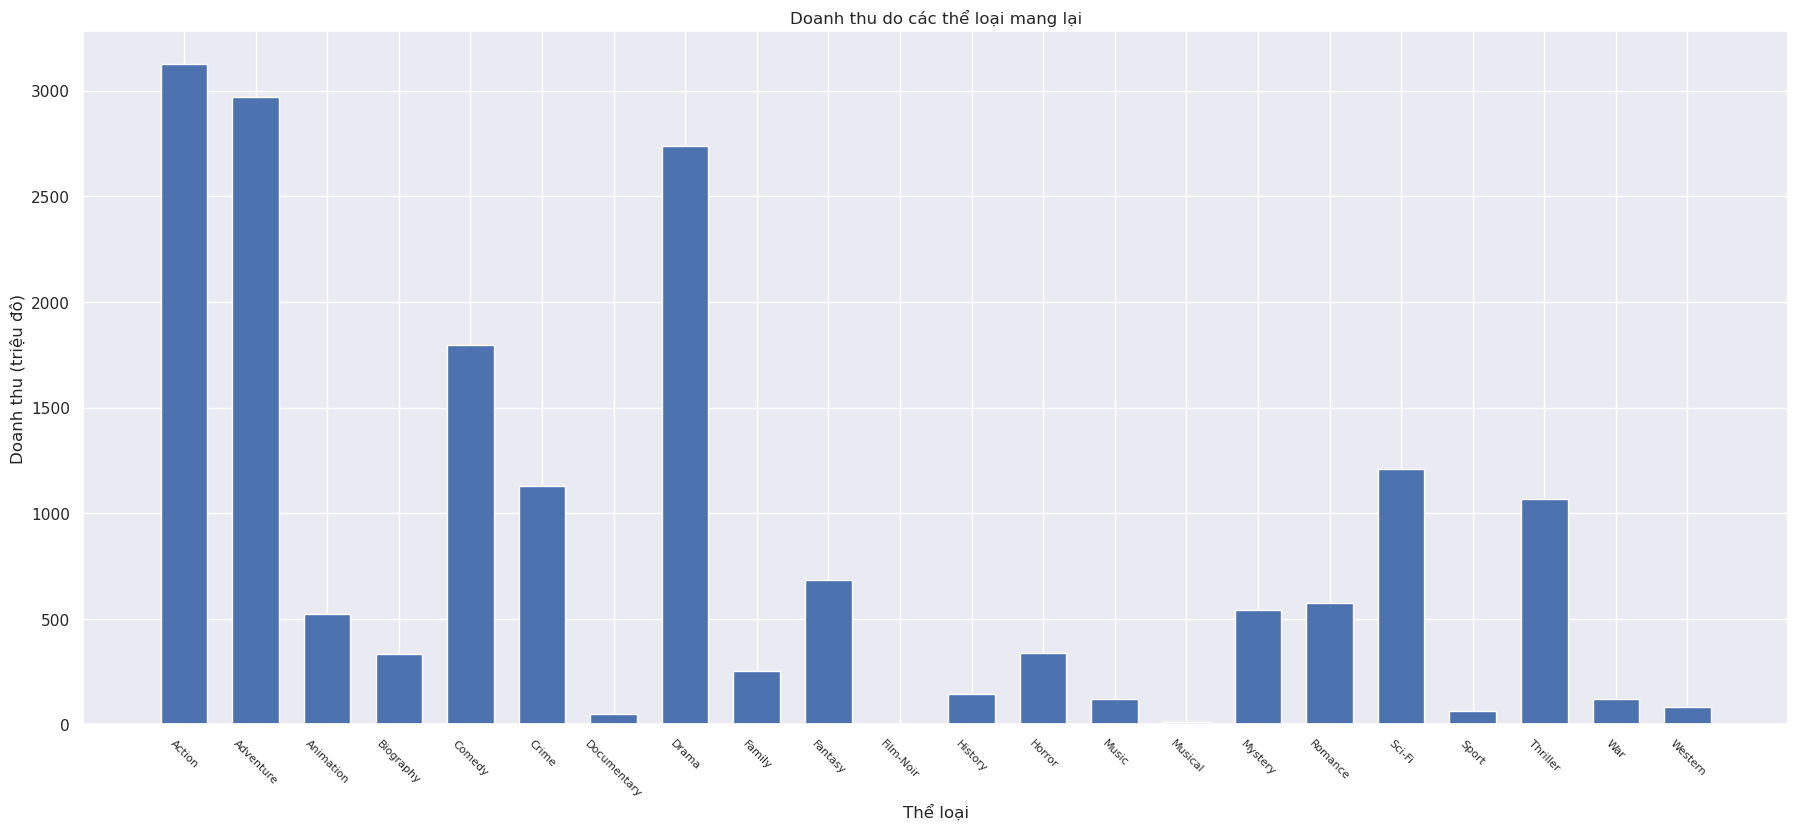

In [157]:
fig =plt.subplots(figsize=(22,9))

genre=np.array(sum_gross_genres.keys())
gross=np.array(sum_gross_genres.values)

plt.bar(genre,gross,width=0.65)
plt.xlabel('Thể loại')
plt.ylabel('Doanh thu (triệu đô)')
plt.title('Doanh thu do các thể loại mang lại')
plt.xticks(genre,size=8)
plt.setp(plt.gca().get_xticklabels(), rotation=-45, horizontalalignment='center')
plt.show()

<h4>Nhận xét:</h4>

- Ta thấy được doanh thu mang về của thể loại Drama vẫn không cao bằng 2 thể loại cùng đứng top là hành động và phiêu lưu.
- Biểu đồ chỉ mang tính *<b>khách quan</b>* vì có sự thay đổi của tỉ giá tiền tệ theo từng thập niên, và cũng còn một số phim chưa thể tổng hợp được tổng doanh thu.

<h4>Số lượng giải </h4>

In [158]:
film_info_df.Wins.unique()

array(['Won 3 Oscars', 'Won 1 Oscar', 'Won 2 Oscars',
       'Nominated for 1 Oscar', 'Won 7 Oscars', 'Nominated for 3 Oscars',
       'Awards', 'Nominated for 7 Oscars', 'Nominated for 4 Oscars',
       'Won 6 Oscars', 'Won 4 Oscars', 'Won 5 Oscars',
       'Won 2 BAFTA Awards', 'Won 1 BAFTA Award',
       'Nominated for 2 Oscars', 'Won 11 Oscars',
       'Nominated for 1 BAFTA Award', 'Nominated for 5 BAFTA Awards',
       'Nominated for 5 Oscars', 'Won 8 Oscars', 'Nominated for 6 Oscars',
       'Nominated for 2 BAFTA Awards', 'Nominated for 10 Oscars', None,
       'Nominated for 3 BAFTA Awards', 'Nominated for 8 Oscars',
       'Nominated for 2 Primetime Emmys',
       'Nominated for 3 Primetime Emmys', 'Won 2 Primetime Emmys',
       'Nominated for 1 Primetime Emmy'], dtype=object)

In [159]:
film_info_df.Wins.value_counts()

Awards                             421
Nominated for 1 Oscar              116
Won 1 Oscar                        106
Nominated for 2 Oscars              60
Won 2 Oscars                        47
Nominated for 3 Oscars              36
Nominated for 1 BAFTA Award         32
Won 3 Oscars                        26
Won 4 Oscars                        23
Won 1 BAFTA Award                   22
Nominated for 4 Oscars              16
Won 5 Oscars                        16
Nominated for 6 Oscars               9
Nominated for 7 Oscars               8
Nominated for 2 BAFTA Awards         7
Nominated for 5 Oscars               7
Won 6 Oscars                         7
Won 7 Oscars                         5
Won 8 Oscars                         4
Nominated for 10 Oscars              3
Won 11 Oscars                        3
Nominated for 3 BAFTA Awards         2
Won 2 BAFTA Awards                   2
Nominated for 1 Primetime Emmy       1
Won 2 Primetime Emmys                1
Nominated for 5 BAFTA Awa

- Xử lý để tính được tổng số giải mà thể loại đó giành được:
    - Ta sẽ chỉ lấy những phim "Won" giải để dễ so sánh
    - Với nội dụng trong từng ô của Wins được hiểu như sau: ví dụ, won 2 oscars là thể loại đó đã thắng được 2 giải, won 11 oscars là thể loại đó thắng được 11 giải

In [160]:
film_won_awards=film_info_df[~film_info_df.Wins.str.findall(r'Won .*').explode().isnull()]
film_won_awards

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,1970,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,1990,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,1990,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,1970,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,978,tt0059742,The Sound of Music,1965,1960,G,172.0,"[Biography, Drama, Family]",[Robert Wise],"[Russel Crouse, Georg Hurdalek, Howard Lindsay]","[Julie Andrews, Eleanor Parker, Christopher Plummer]",8.1,8200000.0,163214286.0,601.0,235440,533.0,134.0,63.0,Won 5 Oscars,/title/tt0059742/
978,979,tt2543164,Arrival,2016,2010,PG-13,116.0,"[Drama, Mystery, Sci-Fi]",[Denis Villeneuve],"[Ted Chiang, Eric Heisserer]","[Forest Whitaker, Jeremy Renner, Amy Adams]",7.9,47000000.0,100546139.0,514.0,694079,2200.0,739.0,81.0,Won 1 Oscar,/title/tt2543164/
980,981,tt4034228,Manchester by the Sea,2016,2010,R,137.0,[Drama],[Kenneth Lonergan],[Kenneth Lonergan],"[Michelle Williams, Casey Affleck, Kyle Chandler]",7.8,9000000.0,47695371.0,1049.0,283474,931.0,515.0,96.0,Won 2 Oscars,/title/tt4034228/
981,982,tt1856101,Blade Runner 2049,2017,2010,R,164.0,"[Action, Drama, Mystery]",[Denis Villeneuve],"[Philip K. Dick, Michael Green, Hampton Fancher]","[Ana de Armas, Ryan Gosling, Harrison Ford]",8.0,150000000.0,92054159.0,150.0,571142,2500.0,564.0,81.0,Won 2 Oscars,/title/tt1856101/


In [161]:
genres_won_awards=film_won_awards.explode('Genres').value_counts(['Genres','Wins']).sort_index().to_frame().reset_index()
print(genres_won_awards)

def sum_awards(vl):
    # num=re.findall(r'\d*',)
    num=int(re.findall(r'\d{1,2}',str(vl))[0])
    return num

temp_count=genres_won_awards.Wins.apply(sum_awards)
genres_won_awards[0]=temp_count*genres_won_awards[0]
genres_won_awards=genres_won_awards.groupby('Genres')[0].sum()
print(genres_won_awards)

      Genres               Wins   0
0     Action  Won 1 BAFTA Award   5
1     Action        Won 1 Oscar  17
2     Action      Won 11 Oscars   1
3     Action       Won 2 Oscars  11
4     Action       Won 3 Oscars   6
..       ...                ...  ..
133      War       Won 8 Oscars   1
134  Western       Won 2 Oscars   1
135  Western       Won 3 Oscars   1
136  Western       Won 4 Oscars   1
137  Western       Won 7 Oscars   1

[138 rows x 3 columns]
Genres
Action         119
Adventure      172
Animation       26
Biography       93
Comedy         107
Crime          117
Documentary     11
Drama          488
Family          30
Fantasy         38
Film-Noir        4
History         36
Horror          11
Music           24
Musical          2
Mystery         32
Romance         92
Sci-Fi          47
Sport           11
Thriller        80
War             41
Western         16
Name: 0, dtype: int64


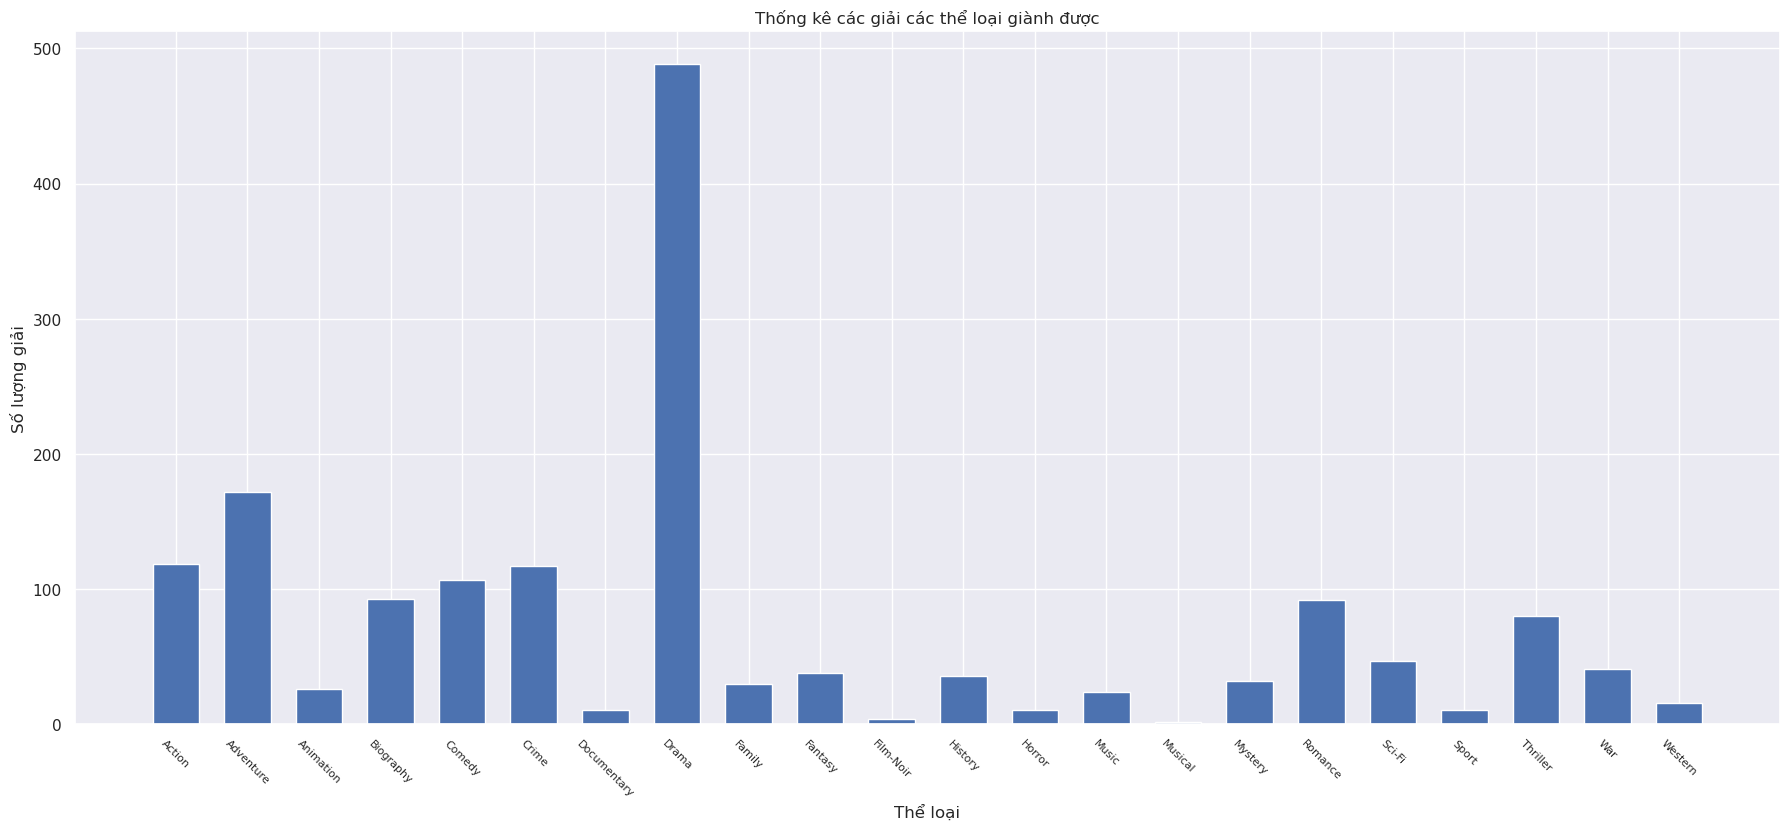

In [162]:
fig =plt.subplots(figsize=(22,9))

genre=np.array(genres_won_awards.keys())
sum_awards=np.array(genres_won_awards.values)

plt.bar(genre,sum_awards,width=0.65)
plt.xlabel('Thể loại')
plt.ylabel('Số lượng giải')
plt.title('Thống kê các giải các thể loại giành được')
plt.xticks(genre,size=8)
plt.setp(plt.gca().get_xticklabels(), rotation=-45, horizontalalignment='center')
plt.show()

<h4>Nhận xét:</h4>

- Nhìn vào biểu đồ trên ta đã hoàn toàn thấy sự khác biệt số lần thắng giải của thể loại Chính kịch(Drama), gấp hơn 2.5 lần so với các thể loại cùng đứng top trên.
- Qua tìm hiểu thêm trên mạng, chính kịch luôn dẫn đầu trong các thể loại được yêu thích trong các thập niên. Được giải thích như sau: 
    + Chính kịch(kết hợp giữa bi kịch và hài kịch): trong lịch sử bi kịch thường chỉ dành cho tầng lớp quý tộc, hài kịch thuộc về dân thường thấp kém, do yếu tố dung hòa giữa 2 thể loại nên phạm vi, đối tượng mà chính kịch hướng tới cũng rộng lớn hơn, đồng thời phản ánh được những câu chuyện, tính cách, tình cảm phức tạp và phong phú hơn.

    + Nhân vật trong phim chính kịch tự tạo lập cuộc sống cá nhân, đi theo ý chí bản thân, nó không chỉ biểu hiện bằng việc nỗ lực hành động để đạt được mục đích của bản thân, mà còn trải qua đấu tranh nội tâm, có ý thức tự giác, phản tư, thế giới tinh thần phong phú. Chính vì vậy, cuộc đời của nhân vật, kết cục của câu chuyện trong phim chính kịch có tính toàn vẹn hơn. Tìm được sự đồng cảm nào đó ở khán giả và nhà phê bình.

    + Phim chính kịch có nhiều phim chuyển thể từ các tiểu thuyết văn hóa lịch sử nổi tiếng.

[Tham khảo](https://filmstutamlang.wordpress.com/2016/11/25/dinh-nghia-ve-phim-chinh-kich/)

<h2>Tổng kết câu trả lời cho câu 1:</h2>
<h3>

- Thể loại được yêu thích nhất mọi thập niên: Chính kịch(Drama)
- Top các thể loại yêu thích kế tiếp *(không mang tính thứ tự - Vì mỗi thập niên có sự thay đổi qua lại vị trí giữa những thể loại đó)*: Phiêu lưu, Tội phạm, Hài kịch, Hành động
</h3>


---

<h1 style="color:orange">PHẦN 2: MÔ HÌNH HÓA DỮ LIỆU</h1>

<h2 style="color:orange">Mô hình hóa dữ liệu</h2>

<h2>Bài toán đặt ra:</h2> 

- Chúng ta đã biết rằng, có rất nhiều kiểu để phân loại một bộ phim. Ví dụ như, phân loại theo thể loại: Hành động, Phiêu lưu, Chính kịch,... , theo độ tuổi xem, R, PG, G,... Hay cũng có xếp hạng theo điểm IMDb, theo độ nổi tiếng. Vậy liệu rắng chúng ta có thể dựa trên các thông tin ở trên để đáng giá một bộ phim thành công nhiều hay ít không.

<h2>Hướng giải quyết:</h2>

- Để giải quyết vấn đề trên nhóm quyết định dựa trên các thuật toán hỗ trợ trong `Sklearn` để cố phân cụm các phim, nhằm đánh giá mức thành công của bộ phim đó.
    
- Dựa trên nhưng giá trị ở các cột để phân cụm:
    - IMDb RATING
    - Popularity
    - Meta score
    - Budget
    - Gross
    - Wins

- Thuật toán sử dụng:
    - K-Means + One hot encoding
    - K-Prototypes: là thuật toán kệt hợp giữa K-Means và K-Modes
    - K-Means: Tự xử lý thông tin 
- Giải thích sử dụng thuật toán:
    - Có 2 kiểu dữ liệu numerical và category.

<h3>Tiền xử lý cho dữ liệu mô hình (tiếp tục)</h3>

In [377]:
cluster_df=cluster_full_info_df.loc[:,['IMDb RATING','Popularity','Meta score','Budget (estimated)','Gross','Wins']]
cluster_df.head(10)

,IMDb RATING,Popularity,Meta score,Budget (estimated),Gross,Wins
0,9.2,92.0,100.0,6000000.0,134966411.0,Won 3 Oscars
1,8.7,194.0,90.0,25000000.0,46836394.0,Won 1 Oscar
2,8.9,115.0,94.0,8000000.0,107928762.0,Won 1 Oscar
3,8.5,425.0,77.0,6000000.0,23341568.0,Won 2 Oscars
4,8.5,307.0,94.0,31500000.0,83471511.0,Won 2 Oscars
5,8.1,784.0,83.0,1830000.0,16501785.0,Nominated for 1 Oscar
6,8.8,139.0,66.0,63000000.0,37030102.0,Nominated for 1 Oscar
7,9.0,219.0,94.0,22000000.0,96898818.0,Won 7 Oscars
8,7.9,462.0,85.0,15000000.0,26400640.0,Nominated for 3 Oscars
9,8.3,381.0,79.0,1200000.0,2832029.0,Awards


In [378]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IMDb RATING         1000 non-null   float64
 1   Popularity          782 non-null    float64
 2   Meta score          963 non-null    float64
 3   Budget (estimated)  895 non-null    float64
 4   Gross               937 non-null    float64
 5   Wins                984 non-null    object 
dtypes: float64(5), object(1)
memory usage: 87.0+ KB


Text(0.5, 1.0, 'Percent missing data by feature')

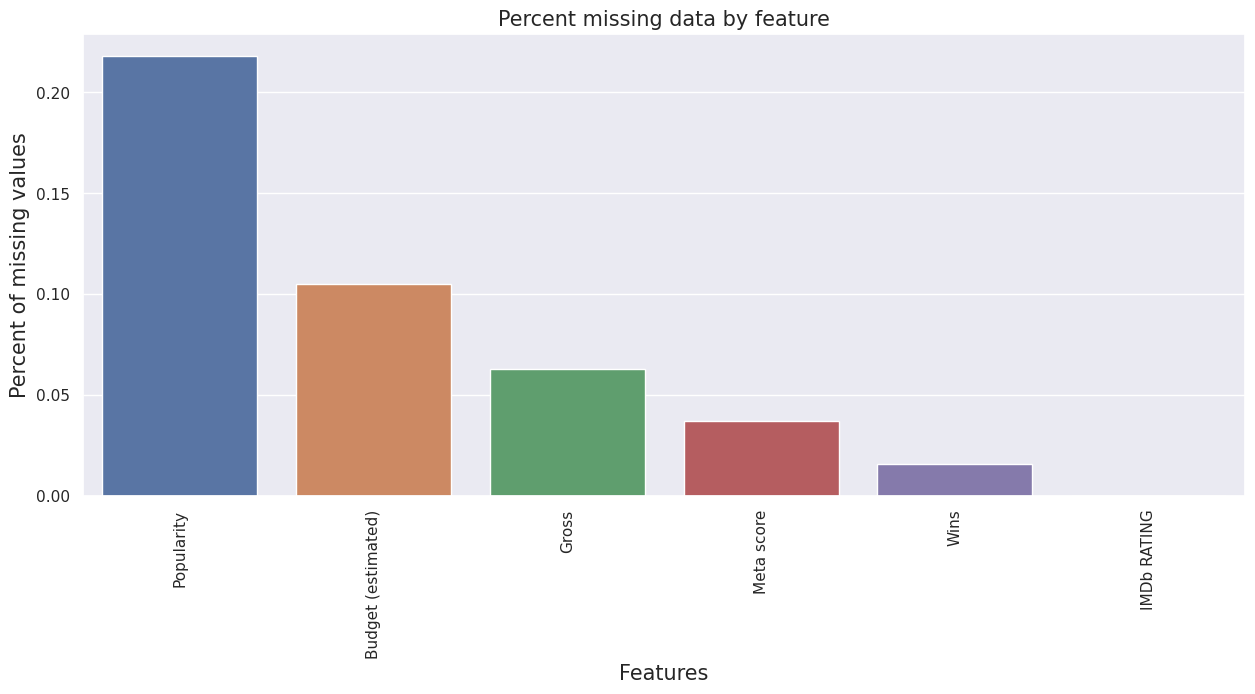

In [379]:
total = cluster_df.isnull().sum().sort_values(ascending=False)
percent = (cluster_df.isnull().sum()/cluster_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

<h4>Xóa các dòng thiếu hơn 2 ô dữ liệu</h4>

In [380]:
cluster_df.dropna(thresh=4,axis=0,inplace=True)
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IMDb RATING         964 non-null    float64
 1   Popularity          779 non-null    float64
 2   Meta score          954 non-null    float64
 3   Budget (estimated)  885 non-null    float64
 4   Gross               931 non-null    float64
 5   Wins                953 non-null    object 
dtypes: float64(5), object(1)
memory usage: 52.7+ KB


<h4>Thực hiện điền giá trị <b>mean</b> vào các ô của các cột dữ liệu numerical</h4>

In [381]:
mean=cluster_df.mean()
mean

IMDb RATING           7.542635e+00
Popularity            1.729376e+03
Meta score            7.436792e+01
Budget (estimated)    3.451354e+07
Gross                 7.106062e+07
dtype: float64

In [382]:
cluster_df['IMDb RATING']=cluster_df['IMDb RATING'].replace(np.nan,mean[0])
cluster_df.Popularity=cluster_df.Popularity.replace(np.nan,mean[1])
cluster_df['Meta score']=cluster_df['Meta score'].replace(np.nan,mean[2])
cluster_df['Budget (estimated)']=cluster_df['Budget (estimated)'].replace(np.nan,mean[3])
cluster_df.Gross=cluster_df.Gross.replace(np.nan,mean[4])

#### Trong dữ liệu ta thấy `Budget` và `Gross` là 2 cột có giá trị trái nhau
- Thực hiện lấy `Gross` \- `Budget`

In [383]:
balance=cluster_df['Gross']-cluster_df['Budget (estimated)']
cluster_df.insert(3,"Balance",np.array(balance.values))
cluster_df

,IMDb RATING,Popularity,Meta score,Balance,Budget (estimated),Gross,Wins
0,9.2,92.0,100.0,128966411.0,6000000.0,134966411.0,Won 3 Oscars
1,8.7,194.0,90.0,21836394.0,25000000.0,46836394.0,Won 1 Oscar
2,8.9,115.0,94.0,99928762.0,8000000.0,107928762.0,Won 1 Oscar
3,8.5,425.0,77.0,17341568.0,6000000.0,23341568.0,Won 2 Oscars
4,8.5,307.0,94.0,51971511.0,31500000.0,83471511.0,Won 2 Oscars
...,...,...,...,...,...,...,...
995,6.7,2463.0,52.0,28348319.0,54000000.0,82348319.0,Awards
996,7.6,1362.0,56.0,15903593.0,25000000.0,40903593.0,Awards
997,7.5,206.0,68.0,-9308792.0,65000000.0,55691208.0,Awards
998,7.2,1207.0,63.0,23722567.0,8500000.0,32222567.0,Awards


In [384]:
cluster_df.drop(['Budget (estimated)','Gross'], axis=1, inplace=True)

<h2>Method 1: K-Means</h2>

#### Xử lý giá cột `Wins`:

- Theo như tìm hiểu trên mạng, nhóm thấy 1 phim trung bình sẽ có thể nhận đến [tối đa 40 đề cử Oscar](https://www.quora.com/How-many-oscar-nominations-can-be-made-for-one-movie-at-maximum), và trong 1 nội dung thắng, thì trung bình có 5 đề cứ. Nên ở đây nhóm mình sẽ cố gắng quy đổi thông tin các giải thưởng mà phim nhận được thành dạng numerical.
- Xem như các giải thưởng thắng được là như ngang nhau trong thứ bậc, và đề cử có đồng giá trị như nhau. Ở đây:
    - 1 Win = 5 Nominations
    - 1 Nomination = 1 Award
    - None = 0
- Mặt khác nhóm còn muốn cột `Wins` đóng vai trò lớn nhất trong phần quyết định rằng phim đó thành công ra sao (Do không có quy ước nào 1 giải sẽ tương ứng với bao nhiêu USD :p, nên nhóm sẽ lấy mean của Balance làm hệ số chung dể nhân lên)


In [385]:
mean_blc=cluster_df.Balance.mean()
def calc_wins(st):
    if st!=None:
        num=re.findall(r'\d{1,2}',str(st))
        if len(num)==0:
            return mean_blc
        if len(re.findall(r'Won',str(st)))>0:
            return 5*int(num[0])*mean_blc
        return int(num[0])*mean_blc
    return 0
    
cluster_df.Wins=cluster_df.Wins.apply(calc_wins)
cluster_df.Wins.unique()

array([5.48206163e+08, 1.82735388e+08, 3.65470775e+08, 3.65470775e+07,
       1.27914771e+09, 1.09641233e+08, 2.55829543e+08, 1.46188310e+08,
       1.09641233e+09, 7.30941551e+08, 9.13676939e+08, 7.30941551e+07,
       2.01008926e+09, 1.46188310e+09, 2.19282465e+08, 0.00000000e+00,
       2.92376620e+08])

<h3>Chạy mô hình</h3>

In [386]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [387]:
X=cluster_df.iloc[:,:5]
X

,IMDb RATING,Popularity,Meta score,Balance,Wins
0,9.2,92.0,100.0,128966411.0,5.482062e+08
1,8.7,194.0,90.0,21836394.0,1.827354e+08
2,8.9,115.0,94.0,99928762.0,1.827354e+08
3,8.5,425.0,77.0,17341568.0,3.654708e+08
4,8.5,307.0,94.0,51971511.0,3.654708e+08
...,...,...,...,...,...
995,6.7,2463.0,52.0,28348319.0,3.654708e+07
996,7.6,1362.0,56.0,15903593.0,3.654708e+07
997,7.5,206.0,68.0,-9308792.0,3.654708e+07
998,7.2,1207.0,63.0,23722567.0,3.654708e+07


<h4>Những siêu tham số cần xác định trong mô hình phân cụm theo K-Means:</h4>

- n_nit: Số lần khởi tạo tâm và chọn giá trị hội tụ phù hợp nhất **(default=10)**, Nhóm muốn tăng số lần khởi tạo để có thể quét được nhiều nhất không gian của đối tượng đó. Chọn `n_nit=50`
- max_iter: Với n_init lần chạy và mỗi lần chạy lặp lại max_iter lần **(default=300)**, được hiểu trong một lần chạy, điểm sẽ được gán cho các cụm khác nhau và chi phí được tính cho max_iter lần. Với max_iter ở giá trị cao, thì ta được đảm bảo rằng sẽ khám phá toàn bộ không gian đối tượng, nhưng đồng nghĩa với chi phí sẽ tăng lên. Chọn `max_iter=500`
- nit: tọa độ tâm của cụm: với lượng dữ liệu lớn, khó để xác định được đúng tâm, nên ở đây nhóm để ở `nit='random'`
- random_state: là hạt giống sinh số ngẫu nhiên, nhằm tránh việc mỗi lần cho ra kết quả khác nhau. Ta có thể chọn bất kỳ giá trị nào, ở đây nhóm chọn `random_state=2020` 
- n_clusters: đóng vai trò **quan trọng nhất**, số cụm, ở đây ngoài cách thử và sai ra thì, khó có thể chọn được siêu tham só này một cách phù hợp nhất. Thử và sai `n_clusters=[2,10]`

In [388]:
for i in range(2,11,1):
    kmean=KMeans(n_clusters=i,init='random',n_init=50,max_iter=500, random_state=2020)
    cluster_df['Clusters']=kmean.fit_predict(X)
    kmean.fit(X)

<h2 style="color:orange">Đánh giá mô hình</h2>

#### Dựa trên SSE do hàm kmeans.inertia trả về ta thực hiện vẽ biểu đồ và chọn `n_clusters` phù hợp nhất.

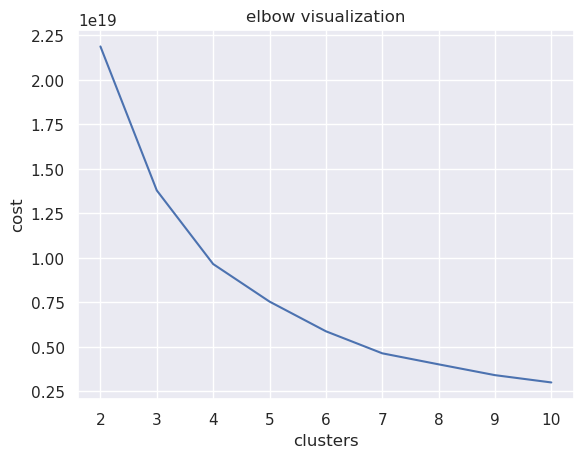

In [389]:
distortions = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

plt.plot(range(2, 11), distortions)
plt.title('elbow visualization')
plt.xlabel('clusters')
plt.ylabel('cost')
plt.show()

<h4>Nhận xét:</h4>

- Ta thấy có sự thay đổi nhiều khi phân từ 2 cụm về 3 cụm. Nhưng khi phân từ 3 cụm trở lên, chi phí không thay đổi nhiều.

#### Kết luận: `n_clusters=3`

<h4>Trực quan kết quả phân cụm với các siêu tham số đã xác định ở trên:</h4>

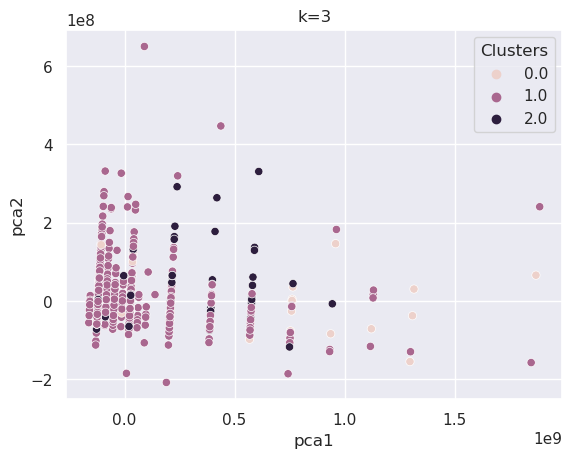

In [390]:
kmean=KMeans(n_clusters=3,init='random',n_init=50,max_iter=500, random_state=2020)
cluster_df['Clusters']=kmean.fit_predict(X)
kmean.fit(X)
reduced_data=PCA(2).fit_transform(X)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=cluster_df.Clusters, data=results)
plt.title(f'k=3')
plt.show()

<h4>Phân cụm các phim theo những cụm mà ta đã xác định ở trên:</h4>

In [391]:
cluster_full_info_df_method1=cluster_full_info_df.copy()
cluster_full_info_df_method1["Clusters"]=cluster_df.Clusters
cluster_full_info_df_method1.Clusters=cluster_full_info_df_method1.Clusters.replace(np.nan,-1)

In [392]:
cluster_full_info_df_method1[cluster_full_info_df_method1.Clusters==2].Wins.unique()

array(['Won 3 Oscars', 'Won 2 Oscars', 'Won 4 Oscars',
       'Won 2 BAFTA Awards', 'Nominated for 10 Oscars',
       'Nominated for 8 Oscars'], dtype=object)

In [393]:
cluster_full_info_df_method1[cluster_full_info_df_method1.Clusters==1].Wins.unique()

array(['Won 1 Oscar', 'Nominated for 1 Oscar', 'Nominated for 3 Oscars',
       'Awards', 'Nominated for 7 Oscars', 'Nominated for 4 Oscars',
       'Won 1 BAFTA Award', 'Nominated for 2 Oscars',
       'Nominated for 1 BAFTA Award', 'Nominated for 5 BAFTA Awards',
       'Nominated for 5 Oscars', 'Nominated for 6 Oscars',
       'Nominated for 2 BAFTA Awards', None,
       'Nominated for 3 BAFTA Awards', 'Nominated for 2 Primetime Emmys',
       'Nominated for 3 Primetime Emmys'], dtype=object)

In [394]:
cluster_full_info_df_method1[cluster_full_info_df_method1.Clusters==0].Wins.unique()

array(['Won 7 Oscars', 'Won 6 Oscars', 'Won 5 Oscars', 'Won 11 Oscars',
       'Won 8 Oscars'], dtype=object)

In [395]:
cluster_full_info_df_method1[cluster_full_info_df_method1.Clusters==-1].Wins.unique()

array(['Awards', 'Nominated for 1 BAFTA Award', 'Won 1 Oscar',
       'Nominated for 1 Oscar', None, 'Nominated for 3 Oscars',
       'Won 2 Primetime Emmys', 'Nominated for 1 Primetime Emmy'],
      dtype=object)

<h4>Nhận xét:</h4>

- Theo kiểm tra bằng mắt với cột `Wins` thì ta thấy phân cụm trên khá hợp lý.

#### Để dễ quan sát hơn ta thực hiện một vài xử lý cột `Clusters`:
- Đổi tên cột `Clusters` thành `Classify`
- Các gía trị trong cột:
    - -1: Chưa xác định 
    - Cụm có 'Won 3 Oscars': Rất thành công
    - Cụm có 'Nominated for 2 Oscars': Thành công
    - Cụm có 'Won 11 Oscars' : Xuất sắc

In [413]:
def clusters_of_film(col):
    return col.Clusters[0]
temp=cluster_full_info_df_method1[~cluster_full_info_df_method1.Wins.str.findall(r'Won 11 Oscars').explode().isnull()]
clus_of_excellent=temp.Clusters.values[0]

temp=cluster_full_info_df_method1[~cluster_full_info_df_method1.Wins.str.findall(r'Won 3 Oscars').explode().isnull()]
clus_of_very_success=temp.Clusters.values[0]

temp=cluster_full_info_df_method1[~cluster_full_info_df_method1.Wins.str.findall(r'Nominated for 2 Oscars').explode().isnull()]
clus_of_success=temp.Clusters.values[0]

cluster_full_info_df_method1.Clusters=cluster_full_info_df_method1.Clusters.replace([-1,clus_of_excellent,clus_of_very_success,clus_of_success],['Chưa xác định ','Xuất Sắc','Rất thành công','Thành công'])
cluster_full_info_df_method1.rename({'Clusters':'Classify'},inplace= True)

In [414]:
cluster_full_info_df_method1.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL,Clusters
0,1,tt0068646,The Godfather,1972,R,175.0,"[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,6000000.0,134966411.0,92.0,1849463,5200.0,193.0,100.0,Won 3 Oscars,/title/tt0068646/,Rất thành công
1,2,tt0099685,Goodfellas,1990,R,145.0,"[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,25000000.0,46836394.0,194.0,1156922,1500.0,163.0,90.0,Won 1 Oscar,/title/tt0099685/,Thành công
2,3,tt0110912,Pulp Fiction,1994,R,154.0,"[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,8000000.0,107928762.0,115.0,2043441,3500.0,306.0,94.0,Won 1 Oscar,/title/tt0110912/,Thành công
3,4,tt0114814,The Usual Suspects,1995,R,106.0,"[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,6000000.0,23341568.0,425.0,1083363,1400.0,154.0,77.0,Won 2 Oscars,/title/tt0114814/,Rất thành công
4,5,tt0078788,Apocalypse Now,1979,R,147.0,"[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,31500000.0,83471511.0,307.0,666884,1300.0,302.0,94.0,Won 2 Oscars,/title/tt0078788/,Rất thành công


<h2>Method 2: K-Means + One hot encoding</h2>